In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
import os
import zipfile
logging.set_verbosity(logging.ERROR)
print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.12.0


In [ ]:
local_zip = '/content/Dataset - Price Prediction.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./data')
zip_ref.close()

In [ ]:
file_price= '/content/data/Data Price Prediction - Bandeng-Grosir.csv'
with open(file_price, 'r') as csvfile:
    print(f"Header looks like this: {csvfile.readline()}")    
    print(f"First data point looks like this: {csvfile.readline()}")

Header looks like this: Bulan,Harga

First data point looks like this: 1/2014,19925



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def parse_data_from_file(filename):
    
    times = []
    price = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        index=0
        for row in reader:
            times.append(index+1)
            price.append(float(row[1])/1000)
            index+=1
            
    return times, price

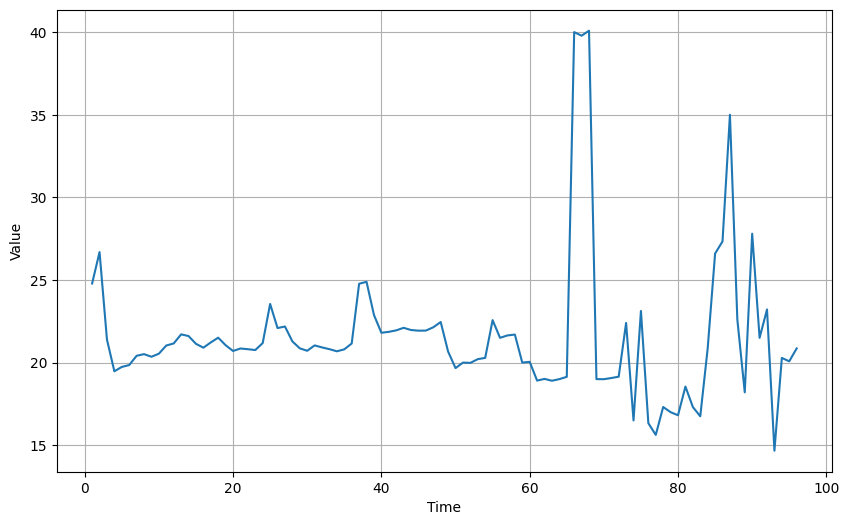

In [ ]:
@dataclass
class G:
    tongkol_eceran= '/content/data/Data Price Prediction - Bandeng-Grosir.csv'
    times, harga = parse_data_from_file(tongkol_eceran)
    TIME = np.array(times)
    SERIES = np.array(harga)
    SPLIT_TIME = 72
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding="causal",activation="relu",input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100)
    ]) 

    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])
    
    return history

In [ ]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_50 (Conv1D)          (None, None, 32)          192       
                                                                 
 bidirectional_113 (Bidirect  (None, None, 64)         16640     
 ional)                                                          
                                                                 
 bidirectional_114 (Bidirect  (None, 64)               24832     
 ional)                                                          
                                                                 
 dense_58 (Dense)            (None, 1)                 65        
                                                                 
 lambda_50 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-tra

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/150
1/1 [==============================] - 6s 6s/step - loss: 11.6601 - mae: 12.1601 - lr: 1.0000e-06
Epoch 2/150
1/1 [==============================] - 0s 86ms/step - loss: 11.6239 - mae: 12.1239 - lr: 1.1220e-06
Epoch 3/150
1/1 [==============================] - 0s 88ms/step - loss: 11.5890 - mae: 12.0890 - lr: 1.2589e-06
Epoch 4/150
1/1 [==============================] - 0s 96ms/step - loss: 11.5475 - mae: 12.0475 - lr: 1.4125e-06
Epoch 5/150
1/1 [==============================] - 0s 88ms/step - loss: 11.4995 - mae: 11.9995 - lr: 1.5849e-06
Epoch 6/150
1/1 [==============================] - 0s 100ms/step - loss: 11.4445 - mae: 11.9445 - lr: 1.7783e-06
Epoch 7/150
1/1 [==============================] - 0s 89ms/step - loss: 11.3820 - mae: 11.8820 - lr: 1.9953e-06
Epoch 8/150
1/1 [==============================] - 0s 82ms/step - loss: 11.3113 - mae: 11.8113 - lr: 2.2387e-06
Epoch 9/150
1/1 [==============================] - 0s 98ms/step - loss: 11.2314 - mae: 11.7314 - lr: 2.51

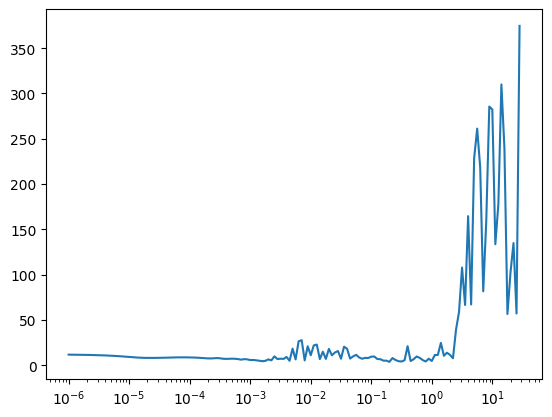

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])

In [ ]:
def create_model():

    
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  metrics=["mae"])  
    return model

In [ ]:
model = create_model()

history = model.fit(train_set, epochs=100)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 44.9502 - mae: 45.4502
Epoch 2/100
1/1 [==============================] - 0s 86ms/step - loss: 40.4716 - mae: 40.9716
Epoch 3/100
1/1 [==============================] - 0s 83ms/step - loss: 36.6163 - mae: 37.1163
Epoch 4/100
1/1 [==============================] - 0s 85ms/step - loss: 32.5209 - mae: 33.0209
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 28.2832 - mae: 28.7832
Epoch 6/100
1/1 [==============================] - 0s 86ms/step - loss: 23.9515 - mae: 24.4515
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 19.5526 - mae: 20.0526
Epoch 8/100
1/1 [==============================] - 0s 100ms/step - loss: 15.1047 - mae: 15.6047
Epoch 9/100
1/1 [==============================] - 0s 137ms/step - loss: 10.6211 - mae: 11.1211
Epoch 10/100
1/1 [==============================] - 0s 120ms/step - loss: 7.9454 - mae: 8.4454
Epoch 11/100
1/1 [==============================] 

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

2/2 [==============================] - 1s 29ms/step
24


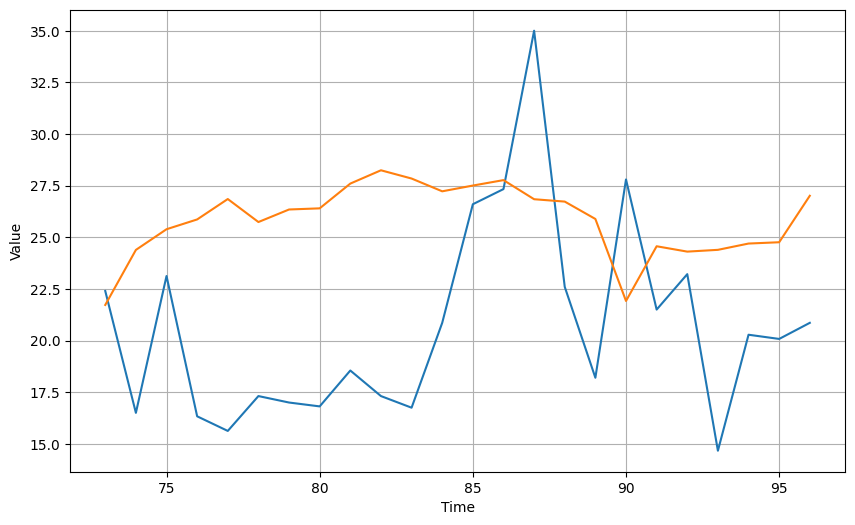

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

print(len(rnn_forecast))
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return mse, mae, mape

In [ ]:
mse, mae, mape = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.5f}, mae: {mae:.5f}, mape: {mape:.5f}")

mse: 52.60942, mae: 6.36289, mape: 34.58168
